<a href="https://colab.research.google.com/github/gilsalvans/DSSG_SS2021/blob/main/Donike_Salvans_DSSG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assessing bias and fairness in the income Adult dataset: Study case for Gender and Race 
This notebook imports the already predicted Adult dataset and assesses bias and fairness using Aequitas and Google What-if for two cases: gender and race.

In [ ]:
#imports
import google.colab
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install aequitas
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap
!pip install --upgrade witwidget

In [ ]:
# Reading data from our repository
# code reused from : https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/WIT_Model_Comparison.ipynb#scrollTo=nu398ARdeuxe
csv_path = 'https://raw.githubusercontent.com/gilsalvans/DSSG_SS2021/main/data/adult.data'

# set columns for the csv
csv_columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"]
# Read the according dataset 
df = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

df

,Age,Workclass,fnlwgt,Education,Education-Num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-per-week,Country,Over-50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education-Num   32561 non-null  int64 
 5   Marital-Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital-Gain    32561 non-null  int64 
 11  Capital-Loss    32561 non-null  int64 
 12  Hours-per-week  32561 non-null  int64 
 13  Country         32561 non-null  object
 14  Over-50K        32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


#Study Case 1: Bias/Fairness assessment for Race (GIL)
This first section focuses on assessing prediction bias on income using race as input variable. Therefore, its structure will start from an analysis of this variable to an assessment using the What-if and Aequitas tools.

In [ ]:
#race variable analysis
race_classes = df['Race'].unique().tolist()
print('There are ', len(race_classes) , 'different race classes in dataset')
race_classes

There are  5 different race classes in dataset


['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other']

In [ ]:
df['Race'].value_counts()

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: Race, dtype: int64

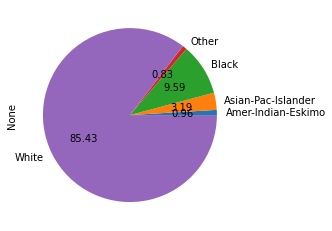

In [ ]:
df.groupby('Race').size().plot(kind='pie', autopct='%.2f')

Note: This plot takes the count per class into account.


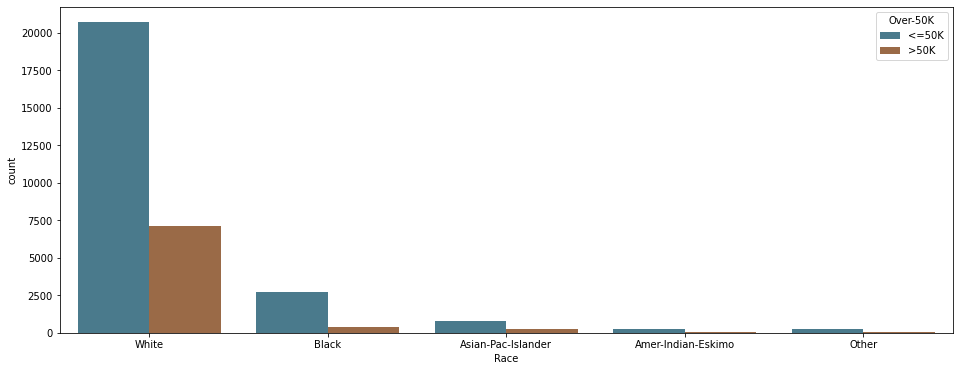

In [ ]:
aq_palette = sns.diverging_palette(225, 35, n=2)
plt.figure(figsize=(16,6))
by_race = sns.countplot(x="Race", hue="Over-50K", data=df[df.Race.isin(['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'])], palette=aq_palette)
print('Note: This plot takes the count per class into account.')

In [ ]:
race = df['Race'].tolist()
income = df['Over-50K'].tolist()

def CountIncomeClasses(race_class):
  count = 0
  count2 = 0

  for i in range(len(df)):
    if race[i] == race_class and income[i] == '>50K':
      count += 1
    elif race[i] == race_class and income[i] == '<=50K':
      count2 += 1

  return count, count2

In [ ]:
black = CountIncomeClasses('Black')
white = CountIncomeClasses('White')
asian_pac_islander = CountIncomeClasses('Asian-Pac-Islander')
amer_indian_eskimo = CountIncomeClasses('Amer-Indian-Eskimo')
other = CountIncomeClasses('Other')

In [ ]:
over50k = [white[0], black[0], asian_pac_islander[0], amer_indian_eskimo[0], other[0]]
under50k = [white[1], black[1], asian_pac_islander[1], amer_indian_eskimo[1], other[1]]

cols = {'race' : race_classes, 'under50k' : under50k, 'over50k' : over50k}
df_race = pd.DataFrame(data=cols)

In [ ]:
percentage_over = []
percentage_under = []

for i in range(len(df_race)):
  value_under = (under50k[i] * 100)/(over50k[i] + under50k[i])
  value_over = (over50k[i] * 100)/(under50k[i] + over50k[i])
  percentage_over.append(value_over)
  percentage_under.append(value_under)

df_race['%_over50k'] = percentage_over
df_race['%_under50k'] = percentage_under

df_race

,race,under50k,over50k,%_over50k,%_under50k
0,White,20699,7117,25.585994,74.414006
1,Black,2737,387,12.387964,87.612036
2,Asian-Pac-Islander,763,276,26.564004,73.435996
3,Amer-Indian-Eskimo,275,36,11.575563,88.424437
4,Other,246,25,9.225092,90.774908


After a generic analysis of this racial variable, some observations are:
 - Most of the censed people are within the white ethnicity.
 - The proportion of censed people who are over or under 50k is quite clustered in two grups: White & Asian with higher predicted incomes than Amer-Indian-Eskimo, Black and Others.
 
It is now time to go on with the bias assessment of the predictions.

#Study Case 1: Bias/Fairness assessment for Gender (SIMON)